In [1]:
import xarray as xr
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12,7)
%matplotlib inline

In [13]:
! wget http://ldeo.columbia.edu/~rpa/NOAA_NCDC_ERSST_v3b_SST.nc

--2018-10-25 13:33:39--  http://ldeo.columbia.edu/~rpa/NOAA_NCDC_ERSST_v3b_SST.nc
Resolving ldeo.columbia.edu (ldeo.columbia.edu)... 129.236.10.30
Connecting to ldeo.columbia.edu (ldeo.columbia.edu)|129.236.10.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://www.ldeo.columbia.edu/~rpa/NOAA_NCDC_ERSST_v3b_SST.nc [following]
--2018-10-25 13:33:39--  http://www.ldeo.columbia.edu/~rpa/NOAA_NCDC_ERSST_v3b_SST.nc
Resolving www.ldeo.columbia.edu (www.ldeo.columbia.edu)... 129.236.14.15
Connecting to www.ldeo.columbia.edu (www.ldeo.columbia.edu)|129.236.14.15|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.ldeo.columbia.edu/~rpa/NOAA_NCDC_ERSST_v3b_SST.nc [following]
--2018-10-25 13:33:40--  https://www.ldeo.columbia.edu/~rpa/NOAA_NCDC_ERSST_v3b_SST.nc
Connecting to www.ldeo.columbia.edu (www.ldeo.columbia.edu)|129.236.14.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43852246 (42M) [

In [2]:
ds = xr.open_dataset('NOAA_NCDC_ERSST_v3b_SST.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 1960-03-15 ...
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

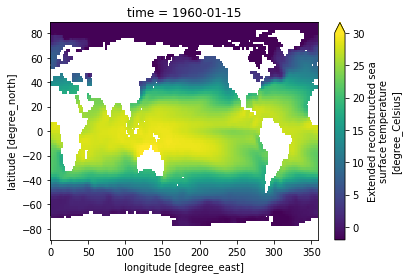

In [3]:
ds.sst[0].plot(vmin=-2, vmax=30)

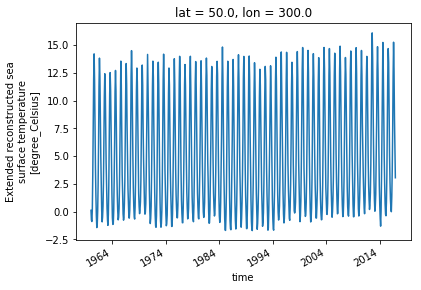

In [4]:
ds.sst.sel(lon=300, lat=50).plot()

In [5]:
ds_mm = ds.groupby('time.month').mean(dim='time')
ds_mm

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, month: 12)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, lat, lon) float32 nan nan nan nan nan nan nan nan nan ...

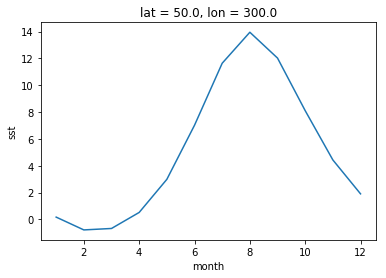

In [6]:
ds_mm.sst.sel(lon=300, lat=50).plot()

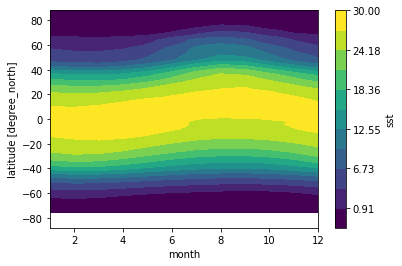

In [7]:
ds_mm.sst.mean(dim='lon').transpose().plot.contourf(levels=12, vmin=-2, vmax=30)

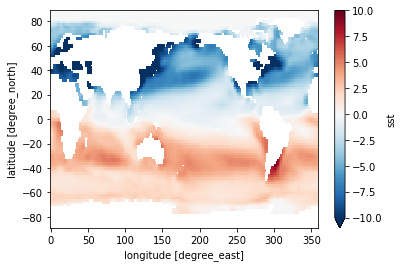

In [8]:
(ds_mm.sst.sel(month=1) - ds_mm.sst.sel(month=7)).plot(vmax=10)

In [10]:
def remove_time_mean(x):
    return x - x.mean(dim='time')

ds_anom = ds.groupby('time.month').apply(remove_time_mean)
ds_anom

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 1960-03-15 ...
Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan nan nan nan nan nan ...
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 ...

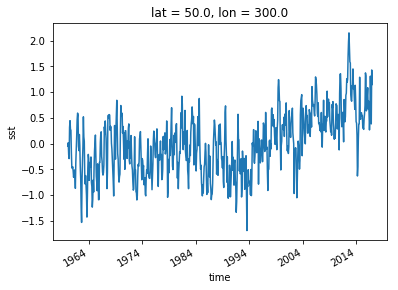

In [11]:
ds_anom.sst.sel(lon=300, lat=50).plot()

In [12]:
ds_anom_resample = ds_anom.resample(time='5Y').mean(dim='time')
ds_anom_resample

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 13)
Coordinates:
  * time     (time) datetime64[ns] 1960-12-31 1965-12-31 1970-12-31 ...
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan nan nan nan nan nan ...
    month    (time) float64 6.5 6.5 6.5 6.5 6.5 6.5 6.5 6.5 6.5 6.5 6.5 6.5 6.5

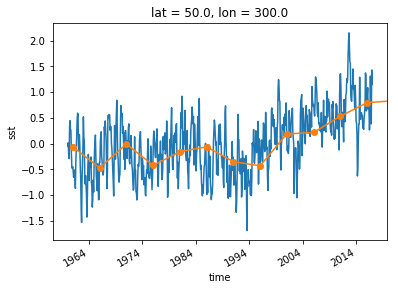

In [13]:
ds_anom.sst.sel(lon=300, lat=50).plot()
ds_anom_resample.sst.sel(lon=300, lat=50).plot(marker='o')

In [14]:
ds_anom_rolling = ds_anom.rolling(time=12, center=True).mean()
ds_anom_rolling

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 1960-03-15 ...
Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan nan nan nan nan nan ...
    month    (time) float64 nan nan nan nan nan nan 6.5 6.5 6.5 6.5 6.5 6.5 ...

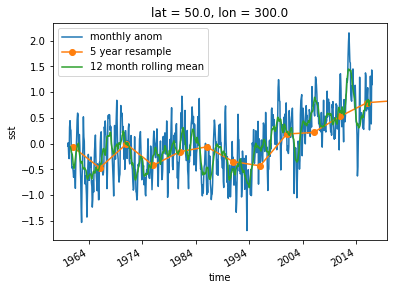

In [15]:
ds_anom.sst.sel(lon=300, lat=50).plot(label='monthly anom')
ds_anom_resample.sst.sel(lon=300, lat=50).plot(marker='o', label='5 year resample')
ds_anom_rolling.sst.sel(lon=300, lat=50).plot(label='12 month rolling mean')
plt.legend()

In [16]:
basin = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods')
basin

<xarray.Dataset>
Dimensions:  (X: 360, Y: 180, Z: 33)
Coordinates:
  * X        (X) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * Y        (Y) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * Z        (Z) float32 0.0 10.0 20.0 30.0 50.0 75.0 100.0 125.0 150.0 ...
Data variables:
    basin    (Z, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

In [17]:
basin = basin.rename({'X': 'lon', 'Y': 'lat'})
basin

<xarray.Dataset>
Dimensions:  (Z: 33, lat: 180, lon: 360)
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * Z        (Z) float32 0.0 10.0 20.0 30.0 50.0 75.0 100.0 125.0 150.0 ...
Data variables:
    basin    (Z, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

In [18]:
basin_surf = basin.basin[0]
basin_surf

<xarray.DataArray 'basin' (lat: 180, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [11., 11., 11., ..., 11., 11., 11.],
       [11., 11., 11., ..., 11., 11., 11.],
       [11., 11., 11., ..., 11., 11., 11.]], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
    Z        float32 0.0
Attributes:
    long_name:  basin code
    valid_max:  58
    scale_min:  1
    units:      ids
    scale_max:  58
    CLIST:      Atlantic Ocean\nPacific Ocean \nIndian Ocean\nMediterranean S...
    valid_min:  1

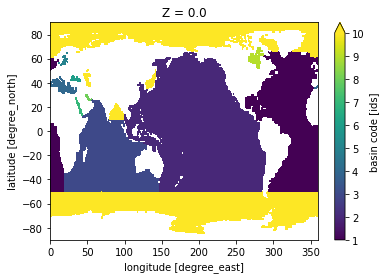

In [19]:
basin_surf.plot(vmax=10)

/opt/conda/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


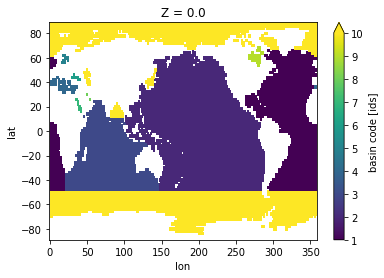

In [20]:
basin_surf_interp = basin_surf.interp_like(ds.sst, method='nearest')
basin_surf_interp.plot(vmax=10)

In [21]:
ds.sst.groupby(basin_surf_interp).first()

<xarray.DataArray 'sst' (time: 684, basin: 14)>
array([[ 5.377986, 11.594195,  5.194623, ..., 14.784468, 11.728802, 26.793444],
       [ 5.843631, 11.409669,  5.363898, ..., 12.760266, 10.920166, 26.912294],
       [ 6.392097, 11.129798,  5.725657, ..., 12.687778, 11.219535, 28.333847],
       ...,
       [ 4.044826,  9.823524,  3.983195, ..., 22.328335, 22.191465, 29.303148],
       [ 4.563355, 10.128197,  4.411432, ..., 19.651663, 18.287334, 28.827768],
       [ 5.186302, 10.773086,  5.126731, ..., 16.851192, 14.252686, 27.837275]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 1960-03-15 ...
  * basin    (basin) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
Attributes:
    pointwidth:          1.0
    valid_min:           -3.0
    valid_max:           45.0
    units:               degree_Celsius
    long_name:           Extended reconstructed sea surface temperature
    standard_name:       sea_surface_temperature
    iridl:ha

In [23]:
basin_mean_sst = ds_mm.sst.groupby(basin_surf_interp).mean()
basin_mean_sst

<xarray.DataArray 'sst' (basin: 14)>
array([19.33996 , 21.234062, 21.165989, 19.939692,  8.14399 , 15.08432 ,
       28.359253, 26.528849,  0.503296,  1.616356, -0.808461, 12.32178 ,
       14.151541, 28.453861], dtype=float32)
Coordinates:
  * basin    (basin) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...

In [24]:
df = basin_mean_sst.to_dataframe()
df

,sst
basin,
1.0,19.339960
2.0,21.234062
3.0,21.165989
4.0,19.939692
5.0,8.143990
6.0,15.084320
7.0,28.359253
8.0,26.528849
9.0,0.503296


In [25]:
import pandas as pd
import numpy as np
basin_names = basin_surf.attrs['CLIST'].split('\n')
basin_df = pd.Series(basin_names, index=np.arange(1, len(basin_names)+1))
basin_df

1                 Atlantic Ocean
2                 Pacific Ocean 
3                   Indian Ocean
4              Mediterranean Sea
5                     Baltic Sea
6                      Black Sea
7                        Red Sea
8                   Persian Gulf
9                     Hudson Bay
10                Southern Ocean
11                  Arctic Ocean
12                  Sea of Japan
13                      Kara Sea
14                      Sulu Sea
15                    Baffin Bay
16            East Mediterranean
17            West Mediterranean
18                Sea of Okhotsk
19                     Banda Sea
20                 Caribbean Sea
21                 Andaman Basin
22               North Caribbean
23                Gulf of Mexico
24                  Beaufort Sea
25               South China Sea
26                   Barents Sea
27                   Celebes Sea
28                Aleutian Basin
29                    Fiji Basin
30          North American Basin
31        

In [26]:
df = df.join(basin_df.rename('basin_name'))

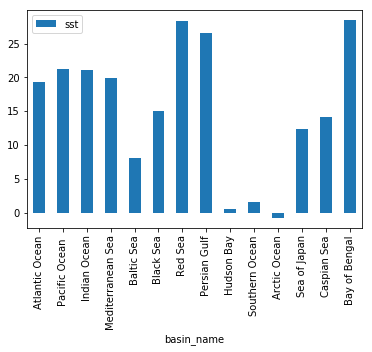

In [27]:
df.plot.bar(x='basin_name')